[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif "Trained Agent"

# Navigation Project - Udacity Deep RL Nano-Degree

### Environment Description - Easier Version (Transformed State, 37 dimensional)
In this notebook we test our implementation of DQN based agent on a specific Unity-ML environment called Banana Collector Environment. In this environment we have a large square area in which the agent can navigate and collect yellow or blue bananas located at various positions in the area. 

Agent can take following four actions at any time step and is tasked with maximizing the number of yellow bananas and minimize the number of blue bananas that it collects over an episode (which as per our measure lasts of ~300  (S, A, R, S') transitions). Basically, the agent recieves a reward of +1 for every yellow banana collected and -1 for every blue banana collected. 
- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

![Trained Agent][image1]

In this version of the environment, state definations are not the raw frames but derived representation of the these frames  which are 37 dimensional continous value vectors. The representations also contain a measure of agent's velocity at any point of time. 

### Solving Criteria (Objective)
This environment is considered solved if the agent achieves an average score of **`13+ in last 100 episodes`**.

### Model and Algorithm

Since the state space is continous in nature hence we can no longer represent the Q-function as a table of value for different states X action pairs. So two obvious way to handle such RL problems is to either 1) discretize the state space and learn the Q-function the usual way or 2) learn a continuous function which maps states and actions to corresponding Q-value. Former option is sometime specially challenging when the state spaces become large, as figuring out the correct discretization scheme and then learning Q-value for each of the discrete states and actions is not always the most sample efficient way to train an agent. Moreover, with the significant success of Deep Neural Architectures in various fields of machine learning like Vision, NLP, etc, showing the significant potential of DNN in learning good representations for Images and NLP, we believe that learning a continous mapping from states and actions to Q-value might be a more viable option.


#### Basic DQN

The architecture of our basic DQN model is as follows

- **`Layer 1`**: Linear Layer (input size = state_size, output_size = 128) followed by a RelU() activation function
- **`Layer 2`**: Linear Layer (input size = 128, output_size = 32) followed by a RelU() activation function
- **`Layer 3`**: Or Output Layer is a Linear Layer (input size = 32, output_size = action_size) which outputs a real valued vector

We aim to learn Q-value function for each state X action pair as a mapping of states to values corresponding to each possible action, using the architecture above. The algorithm that we use is called Q-Learning algorithm which can be described in brief in following bullet points.
- **`Q-Learning - Temporal Difference`**: In Sarsamax we learned to update the $Q(S,A)$ function after every step using the equation $Q(S_t,A_t) = Q(S_t,A_t) + {alpha}*[R_{t+1} + max_A Q(S_{t+1}, A) - Q(S_t,A_t)]$. Q was a mapping form each state X action to the corresponding value. But, this can't be applied when Q is a function parameterized by a DNN, as what we need a cost function which can then be differentiated w.r.t. the parameters of the Network. So, in DQN learning we convert the above equation to an equivalent cost function given by square error between $R_{t+1} + max_A Q(S_{t+1}, A)$ and $Q(S_t,A_t)$ and that is what we trying to minimize in Deep Q-Learning algorithm.
- **`Fixed Q-Targets`**: Instead of obtaining both $max_A Q(S_{t+1}, A)$ and $Q(S_t,A_t)$ terms from the same network parameters and hence allowing the gradients to flow in both of the these terms, which leads to significant stability issues during training of DQN model - arising because of correlations in update and next action (and hence next state) and hence consecutive samples (which is used for further updates); in the [DQN paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) the authors found that using a lagged network with weights only getting updates after a a few thousand update steps led to stable training of DQN model. So the proposed loss function looks like $||[R_{t+1} + max_A Q_{\theta^-}(S_{t+1},A)] - Q_{\theta}(S_t,A_t)||^2$, where ${\theta^-}$ are copied over from the ${primary}$ network to the ${target}$ network every thousand steps or so in the paper, and the value of $max_A Q_{\theta^-}(S_{t+1},A)$ is then obtained from this ${target}$ network.
- **`Experience Replay`**: Also in the same [DQN paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), authors propose that using a random mini-batch sample of SARS transitions from a memory of recent transitions in order to update the DQN model lead to further improvement in training stability. This may be attributed to the possibility that random sampling of such transitions will lead to further reduction in correlations between updates and available samples for updates. 

For more details please check the DQN paper from the above links.

#### Duelling DQN
In addition to the basic DQN model, we have also implemented a Duelling Architecture proposed in the [paper](https://arxiv.org/abs/1511.06581). 

The only architectural change in this variant is the presence of an additional linear output layer in parallel to the existing **`Layer 3`**. Though, unlike the existing layer this one only outputs a scaler value which is supposed to represent the Average Value of the State $V(S)$. Authors claim that this change leads to better (more stable) policy evaluation in the presence of many similar-valued actions.

- **`Parallel Layer 3`**: Linear Layer (input size = 32, output_size = 1) which outputs a real valued scalar V(S)

The other change is in the way the output $Q(S,A)$ is computed from the network i.e. $Q(S,A) = V(S) + [A(S,A) - avg_A A(S,A)]$, where $A(S,A)$ is called an Advantage Function and is the output of the primary **`Layer 3`** and $V(S)$ is the output of **`Parallel Layer 3`**.

#### Double DQN
We also implemented the change in basic DQN proposed in the [Double DQN paper](https://arxiv.org/abs/1509.06461). As per the author of this paper Vanilla DQN tends to over-estimate the value of a $(S_t,A_t)$ because of the max operation in calculating the next state value i.e. $max_A Q(S_{t+1}, A)$, and by calculating the target value using $R_{t+1} + Q_{\theta^-}(S_{t+1},argmax_A Q_{\theta}(S_{t+1},A))$ instead of $R_{t+1} + max_A Q_{\theta^-}(S_{t+1},A)$ will lead to some kind of averaging as the max value action and the value for that action is coming from different networks (note ${\theta}$ and ${\theta^-}$).

#### Prioritized Replay
Vanilla DQN uses a uniform random sampling over the replay memory buffer to get the mini-batch for parameter updates. The [Prioritized Replay paper](https://arxiv.org/abs/1511.05952) proposes to do weighted sampling with weights being decided by the absolute TD-error $\delta = |[R_{t+1} + max_A Q_{\theta^-}(S_{t+1},A)] - Q_{\theta}(S_t,A_t)|$ for each transition. The sampling probability is considered to be proportional to ${\delta}^{\alpha}$, where alpha a parameter which controls the emphasis that we want to put TD-error while deciding the sampling probability ($0 <= \alpha <= 1$). Moreover, since the uniform sampling is supposed to lead us to an unbiased estimation of optimal policy, doing a weighted sampling may lead us to an biased one. So the authors porpose to use a transition level weight while updating from the sampled mini-batch, which is given by  $[(1/N) (1/P(i))]^\beta$, where $N$ is the number of samples in the memory and $P(i)$ is the probability of sampling the ith transition from the memory.


#### Simple ploting utility function for looking at score variation over episodes

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
def score_plot(output_scores):
    l = len(output_scores)
    first_100_sum = sum(output_scores[:100])
    arr = [0]*(l-99)
    arr[0] = first_100_sum/100.
    for i in range(101,l+1):
        arr[i-100] =  (arr[i-101]*100. - output_scores[i-101] + output_scores[i-1])/100.
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    axs[0].plot(range(100,l+1), arr, 'tab:orange')
    axs[0].set_title('average of 100 episodes')
    axs[0].grid()
    axs[1].plot(range(l), output_scores)
    axs[1].set_title('episode level score')

    for ax in axs.flat:
        ax.set(xlabel='episode', ylabel='score')
    
    plt.yticks([0,5,10,11,12,13,14,15,20])
    plt.show()

#### Defining parameters for training a basic DQN agent

In [2]:
from dqnLoop import banana_collector_dqn_training_loop
params = {}
params["n_episodes"] = 600         # maximum number of training episodes
params["max_t"] = 1000             # maximum number of timesteps per episode
params["eps_start"] = 1.           # starting value of epsilon, for epsilon-greedy action selection
params["eps_end"] = 0.01           # minimum value of epsilon
params["eps_decay"] = 0.995        # multiplicative factor (per episode) for decreasing epsilon

# Parameters for controlling dependence of sampling probability on TD-error in Prioritized Experience Replay
params["alpha0"] = 0.0             # Initial value of alpha parameter in Prioritized Experience Replay 
params["alphaf"] = 0.25            # Final value of alpha parameter in Prioritized Experience Replay 
params["nsteps_alpha"] = 250       # Number of episodes in which to linearly change alpha from alpha0 to alphaf

# Parameters for controlling Importance Sampling weight (ISw) in Prioritized Experience Replay
params["beta0"] = 0.2              # Final value of beta parameter in Prioritized Experience Replay
params["betaf"] = 1                # Initial value of beta parameter in Prioritized Experience Replay
params["nsteps_beta"] = 500        # Number of episodes in which to linearly change beta from beta0 to betaf

#DQN Update Parameters
params["LR"] = 1e-3                # Learning Rate for update of DQN weights
params["BUFFER_SIZE"] = 100000     # Size of the Replay Buffer
params["TAU"] = 1e-2               # Fraction of primary network weights to be copied over to the target network after each parameter update step 
                                        # θ_target = τ*θ_primary + (1 - τ)*θ_target
params["BATCH_SIZE"] = 64          # Size of the sample to be selected at random from the Replay Buffer at each update step
params["UPDATE_EVERY"] = 4         # Number of actions (or transitions to be recorded) to be taken before making any update to DQN weights
params["SAMPLE_FREQ"] = 1          # Number of batch sampling and DQN weight update steps to be carried out during the update step
params["GAMMA"] = 0.9              # Discount Factor
params["IS_DDQN"] = False          # Whether to enable the Double DQN improvement or continue with basic DQN
params["MEMORY_TYPE"] = "normal"   # Whether to go with prioritized memory buffer or uniform
params["IS_DUELING"] = False       # Whether to enable Dueling Network improvement or not

# Choice of State
params["STATE_TYPE"] = "normal"    # Whether to train the Agent from raw pixel states or processed state vectors
params["ENVIRONMENT_PATH"] = "Banana.app" # Complete path to the Banana Collector Environment file

params["seed"] = 1234              # random seed

#### Training a basic DQN Agent
    - Basic DQN Agent Takes longer then 500 episodes to solve the easier Banana Collector Environment. Probably in another 100 episodes it might have solved it, but we thought of moving to better methods based on Double DQN and Dueling Networks.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 37)
Episode 100	Average Score: 0.67	Average Episode Len : 300.0
Episode 200	Average Score: 3.12	Average Episode Len : 300.0
Episode 300	Average Score: 6.61	Average Episode Len : 300.0
Episode 400	Average Score: 9.67	Average Episode Len : 300.0
Episode 500	Average Score: 11.31	Average Episode Len : 300.0
Episode 600	Average Score: 12.50	Average Episode Len : 300.0
******************* watch trained agent in action **********************
Score of the sample episode after training: 4.0


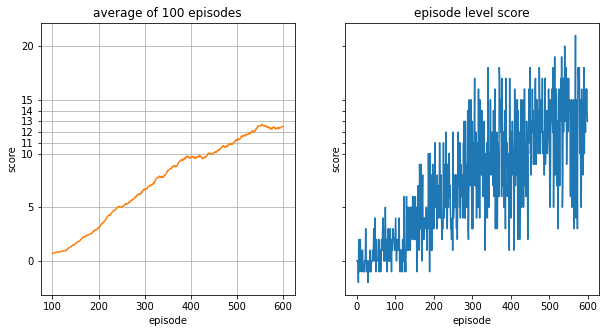

In [2]:
# Basic DQN
output_scores = banana_collector_dqn_training_loop(params)
score_plot(output_scores)

#### Training a Double DQN Agent
    - Double DQN Agent solves the easier environment in around 393 episodes.
    - Please take a look at the plot of scores over episodes to verify the same.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 37)
Episode 100	Average Score: 0.94	Average Episode Len : 300.0
Episode 200	Average Score: 4.38	Average Episode Len : 300.0
Episode 300	Average Score: 7.46	Average Episode Len : 300.0
Episode 400	Average Score: 10.06	Average Episode Len : 300.0
Episode 493	Average Score: 13.03	Average Episode Len : 300.0
Environment solved in 393 episodes!	Average Score: 13.03
Saving DQN weights in ./checkpoint.pth
******************* watch trained agent in action **********************
Score of the sample episode after training: 11.0


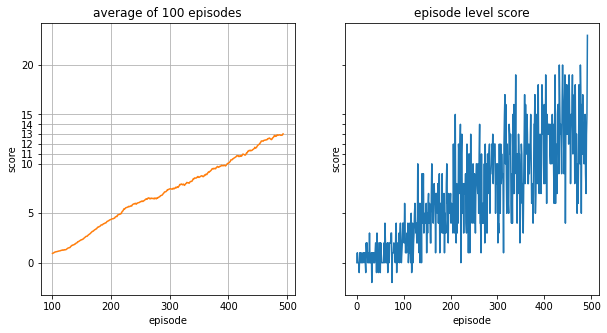

In [3]:
params["IS_DDQN"] = True
# Double DQN
output_scores = banana_collector_dqn_training_loop(params)
score_plot(output_scores)

#### Training a Dueling DQN Agent
    - Double DQN Agent solves the easier environment in around 473 episodes.
    - Please take a look at the plot of scores over episodes to verify the same.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 37)
Episode 100	Average Score: 0.35	Average Episode Len : 300.0
Episode 200	Average Score: 3.82	Average Episode Len : 300.0
Episode 300	Average Score: 7.39	Average Episode Len : 300.0
Episode 400	Average Score: 8.79	Average Episode Len : 300.0
Episode 500	Average Score: 11.65	Average Episode Len : 300.0
Episode 573	Average Score: 13.04	Average Episode Len : 300.0
Environment solved in 473 episodes!	Average Score: 13.04
Saving DQN weights in ./checkpoint.pth
******************* watch trained agent in action **********************
Score of the sample episode after training: 15.0


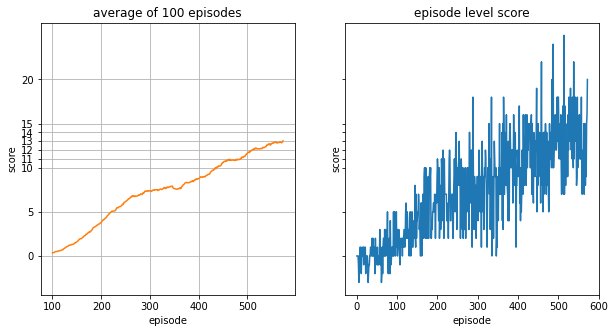

In [3]:
params["IS_DUELING"] = True
# Dueling
output_scores = banana_collector_dqn_training_loop(params)
score_plot(output_scores)

#### Training a Dueling Architecture with Double DQN Agent
    - Double DQN Agent solves the easier environment in around 438 episodes.
    - Please take a look at the plot of scores over episodes to verify the same.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 37)
Episode 100	Average Score: 0.79	Average Episode Len : 300.0
Episode 200	Average Score: 4.75	Average Episode Len : 300.0
Episode 300	Average Score: 8.48	Average Episode Len : 300.0
Episode 400	Average Score: 10.78	Average Episode Len : 300.0
Episode 500	Average Score: 12.56	Average Episode Len : 300.0
Episode 538	Average Score: 13.00	Average Episode Len : 300.0
Environment solved in 438 episodes!	Average Score: 13.00
Saving DQN weights in ./checkpoint.pth
******************* watch trained agent in action **********************
Score of the sample episode after training: 20.0


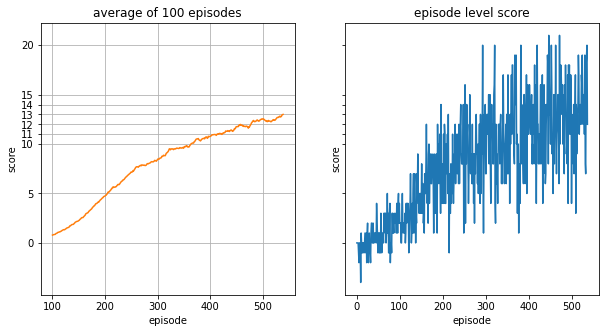

In [3]:
from dqnLoop import banana_collector_dqn_training_loop
params["IS_DDQN"] = True
params["IS_DUELING"] = True
# Double DQN + Dueling
output_scores = banana_collector_dqn_training_loop(params)
score_plot(output_scores)

#### Testing our implementation of Prioritized replay
    - We are testing with alpha = 0 and Beta = 0 which should make this equivalent to agent without it, so we are actually training a Double DQN agent here.
    - Double DQN Agent this time solves the easier environment in around 399 episodes.
    - Please take a look at the plot of scores over episodes to verify the same.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 37)
Episode 100	Average Score: 1.13	Average Episode Len : 300.0
Episode 200	Average Score: 4.41	Average Episode Len : 300.0
Episode 300	Average Score: 8.34	Average Episode Len : 300.0
Episode 400	Average Score: 10.34	Average Episode Len : 300.0
Episode 499	Average Score: 13.05	Average Episode Len : 300.0
Environment solved in 399 episodes!	Average Score: 13.05
Saving DQN weights in ./checkpoint.pth
******************* watch trained agent in action **********************
Score of the sample episode after training: 19.0


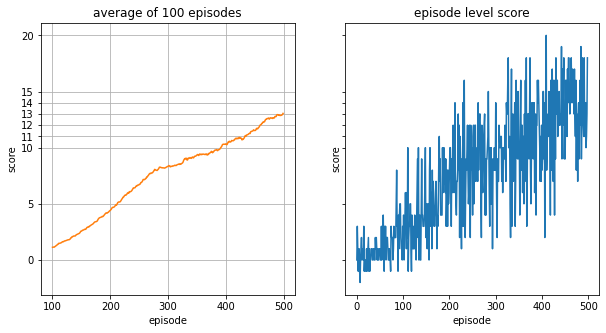

In [4]:
params["IS_DDQN"] = True
params["alpha0"] = 0
params["alphaf"] = 0
params["nsteps_alpha"] = 400
params["beta0"] = 0
params["betaf"] = 0
params["nsteps_beta"] = 500

params["MEMORY_TYPE"] = "prioritized"
# Double DQN only (testing if prioritized replay works similar to Double DQN when alpha and beta is zero 
# Which it should
output_scores = banana_collector_dqn_training_loop(params)
score_plot(output_scores)

#### Training an agent with Prioritized replay and Double DQN
    - We were not able to solve the environment with prioritized replay current, we are assuming that might be because of some bug in our current implementation or may be further parameter tuning is needed for prioritized replay to work. We will explore these directions going forward.
    - Please take a look at the plot of scores over episodes to verify the same.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States have shape: (1, 37)
Episode 100	Average Score: 1.09	Average Episode Len : 300.0
Episode 200	Average Score: 4.20	Average Episode Len : 300.0
Episode 300	Average Score: 8.31	Average Episode Len : 300.0
Episode 400	Average Score: 8.17	Average Episode Len : 300.0
Episode 500	Average Score: 7.77	Average Episode Len : 300.0
Episode 600	Average Score: 7.07	Average Episode Len : 300.0
******************* watch trained agent in action **********************
Score of the sample episode after training: 4.0


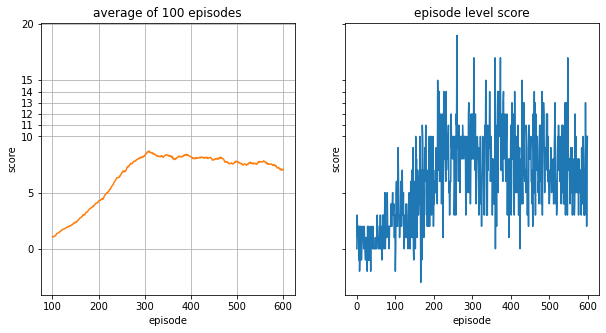

In [5]:
params["IS_DDQN"] = True
params["alpha0"] = 0
params["alphaf"] = 1.
params["nsteps_alpha"] = 500
params["beta0"] = 0.2
params["betaf"] = 1.
params["nsteps_beta"] = 500

params["MEMORY_TYPE"] = "prioritized"
# Double DQN + Priortized Replay
output_scores = banana_collector_dqn_training_loop(params)
score_plot(output_scores)

### Future Work
In order to further improve our agents performance on simpler navigation task we are thinking of implementing the following changes going forward.
- Debug prioritized replay implementation and/or tune hyperparameter associated with it.
- Employ a Hyper-parameter Optimization library (python has one - hyperopt) to tune all the parameters of the training proceedure.
- Instead of selecting actions based on e-greedy strategy, use boltzman probability distribution over the current action value generated from the network, and select the actions randomly according to this distribution. Use a temperature parameter which gradually decreases while training and hence allow us to gradually make the distribution more and more peaked towards optimal action, similar to how epsilon varies in e-greedy strategy.
- Implement and try-out some other improvements considered in the [Rainbow paper](https://arxiv.org/pdf/1710.02298.pdf) like multi-step bootstrap targets, Noisy DQN and Distributional DQN.